In [ ]:
from typing import Tuple

import torch
from torch import nn, Tensor
from torch.distributions.beta import Beta
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms
import torch.backends.cudnn as cudnn

import matplotlib.pyplot as plt
import numpy as np

from tqdm.notebook import tqdm_notebook

In [ ]:
class MixUpModule(nn.Module):
    """
    Module MixUp that mixes batch and labels with a parameter lambda sampled from a beta distribution.
    Code overview :
    >>> lambda ~ Beta(alpha, alpha)
    >>> lambda = max(lambda, 1 - lambda)
    >>> batch = batch_a * lambda + batch_b * (1 - lambda)
    >>> label = label_a * lambda + label_b * (1 - lambda)
    Notes:
            - if alpha -> 0 and apply_max == True, lambda sampled near 1,
            - if alpha -> 1 and apply_max == True, lambda sampled from an uniform distribution in [0.5, 1.0],
            - if alpha -> 0 and apply_max == False, lambda sampled near 1 or 0,
            - if alpha -> 1 and apply_max == False, lambda sampled from an uniform distribution in [0.0, 1.0],
    """

    def __init__(self, sample_lambda: bool = True, _lambda: float = 0.5, alpha: float = 0.4, apply_max: bool = False) -> None:
        """
        Build the MixUp Module.
        :param alpha: Controls the Beta distribution used to sample the lambda coefficient. (default: 0.4)
        :param apply_max: If True, apply the 'lambda = max(lambda, 1 - lambda)' after the sampling of lambda. (default: False)
                This operation is useful for having a mixed batch close to the first batch passed as input.
                It was set to True in MixMatch training but not in original MixUp training.
        """
        super().__init__()
        self.alpha = alpha
        self.apply_max = apply_max

        self.sample_lambda = sample_lambda
        if self.sample_lambda:
            self._beta = Beta(alpha, alpha)
        self._lambda = _lambda

    def forward(
        self,
        xa: Tensor,
        xb: Tensor,
        ya: Tensor,
        yb: Tensor,
    ) -> Tuple[Tensor, Tensor]:
        """
        Apply MixUp to batches and labels.
        """
        if xa.shape != xb.shape or ya.shape != yb.shape:
            raise RuntimeError(
                "Invalid shapes for MixUp : ({} != {} or {} != {})".format(
                    xa.shape, xb.shape, ya.shape, yb.shape
                )
            )

        # Sample from Beta distribution
        if self.sample_lambda:
            self._lambda = self._beta.sample().item() if self.alpha > 0.0 else 1.0

        if self.apply_max:
            self._lambda = max(self._lambda, 1.0 - self._lambda)

        batch_mix = xa * self._lambda + xb * (1.0 - self._lambda)
        labels_mix = ya * self._lambda + yb * (1.0 - self._lambda)

        return batch_mix, labels_mix

    def get_last_lambda(self) -> float:
        """
        :returns: the last lambda sampled. If no data has been passed to forward(), returns 0.0.
        """
        return self._lambda

# Chargement de CIFAR10

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# batch_size = 4
batch_size = 32

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
def imshow(images, labels=None, predicted_labels=None):
    # Using torchvision to make a grid of the images
    img = torchvision.utils.make_grid(images)

    img = img / 2 + 0.5     # unnormalize
    img = img.permute(1, 2, 0)

    # Plotting the grid
    fig, ax = plt.subplots(figsize=(12, 48))
    plt.imshow(img)

    if predicted_labels is not None:
        # labels prédits si elles existent
        ax.set_xlabel('Predicted labels', fontsize=18, labelpad=12)
        ax.set_xticks(torch.arange(len(images)) * 35 + 20)
        ax.set_xticklabels([classes[predicted_labels[j]]
                            for j in range(len(images))], fontsize=14)

    # labels ground truth
    gax = ax.secondary_xaxis('top')
    # gax.set_xlabel('Ground truth', fontsize=18, labelpad=12)
    gax.set_xticks(torch.arange(len(images)) * 35 + 20)
    if labels is not None:
        gax.set_xticklabels([classes[labels[j]]
                         for j in range(len(images))], fontsize=14)
    plt.show()

# Test mixup

In [ ]:
# Images random du train
dataiter = iter(trainloader)
images1, labels1 = next(dataiter)
images2, labels2 = next(dataiter)

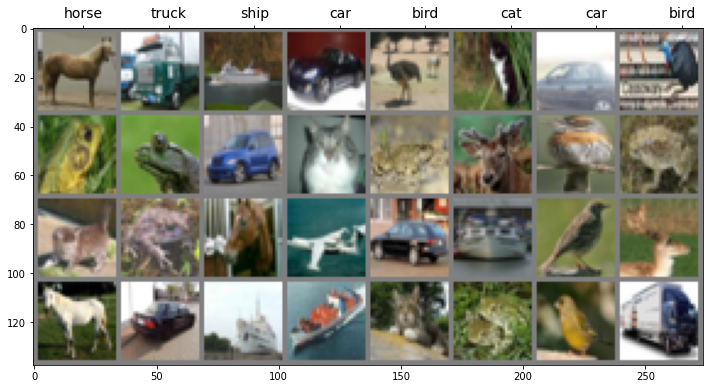

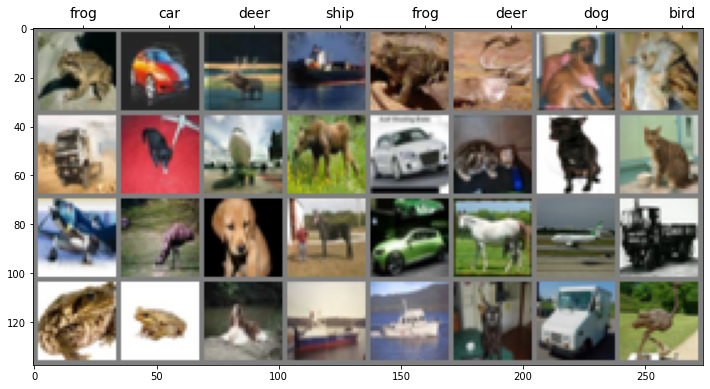

In [ ]:
imshow(images1, labels1)
imshow(images2, labels2)

# Essayer Mixup avec les arguments par défaut

In [ ]:
mixup = MixUpModule(True, 0.5, 1, False)

In [ ]:
mixed_x, mixed_y = mixup(images1, images2, labels1, labels2)
print(f"lambda = {mixup.get_last_lambda():.3f}")
print(mixed_y)

lambda = 0.841
tensor([6.8409, 7.7276, 7.3638, 2.1134, 2.6362, 3.1591, 1.6362, 2.0000, 6.4772,
        5.8409, 0.8409, 3.1591, 5.2047, 3.8409, 2.4772, 5.5228, 2.5228, 5.3638,
        6.6819, 1.1134, 1.0000, 7.8409, 1.6819, 4.7953, 6.8409, 1.7953, 7.5228,
        8.0000, 3.7953, 5.5228, 3.1134, 7.8866])


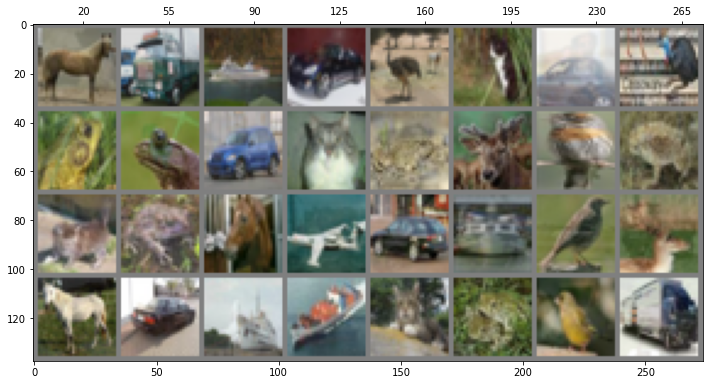

In [ ]:
imshow(mixed_x)

# Essayer Mixup avec différentes valeurs de alpha

# Essayer Mixup avec des valeurs que vous fixez pour lambda, sans sampling

# CNN avec et sans Mixup

Entraîner et tester sur CIFAR10 un réseau CNN from scratch sans et avec Mixup.

!!! Attention changer le batch size à 64 et non 4 dans la cellule en haut du notebook pour les dataloaders, sinon ce sera très très lent (et moins performant)

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cuda:0


In [ ]:
def train(testloader, trainloader, model, opt, crit, use_mixup=False, n_epoch=2, loss_every=500):
    """
    Entraînement d'un modèle et plot des courbes de loss et accuracy
    """
    model.train()
    losses = []
    acc = []
    for epoch in range(n_epoch):  # loop over the dataset multiple times
        print(f"Epoch {epoch}.")

        running_loss = []
        running_acc = []
        print("Train.")
        for i, data in tqdm_notebook(enumerate(trainloader), total=len(trainloader)):

            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # Mettre à zero les gradients des poids du modèle
            opt.zero_grad()

            # forward + backward + optimize
            if use_mixup:
              outputs, mixed_labels = model(inputs, labels)
              loss = crit(outputs, mixed_labels)
            else:
              outputs = model(inputs)
              loss = crit(outputs, labels)
            loss.backward()
            opt.step()

            predicted = torch.argmax(outputs, dim=1)

            running_loss.append(loss.item())
            running_acc.append((predicted == labels).sum().item() / labels.size(0))

            # calculer une moyenne
            if i % loss_every:
                losses.append(np.mean(running_loss))
                acc.append(np.mean(running_acc))

                running_loss = []
                running_acc = []

        test_acc = accuracy(testloader, model)
        print(f"Test accuracy: {test_acc:.3f}")

    fig, axes = plt.subplots(1, 2)
    axes[0].plot(losses)
    axes[1].plot(acc)

    axes[0].set_ylabel("Train loss")
    axes[1].set_ylabel("Train acc")
    plt.show()
    print('Apprentissage terminé')


def accuracy(loader, model):
    """
    Args:
        loader: data loader sur lequel on veut calculer une accuracy
        model
    Returns:
        Accuracy
    """
    with torch.no_grad():
        model.eval()  # remove potential dropout, ...
        n_correct = 0
        n_total = 0
        for i, data in tqdm_notebook(enumerate(loader), total=len(loader)):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # forward + backward + optimize
            outputs = model(inputs)
            predicted = torch.argmax(outputs, dim=1)
            n_correct += (predicted == labels).sum()
            n_total += labels.size(0)
        return n_correct / n_total


def validate(loader, model):
    """
    Plot des predictions faites avec model, affiche l'accuracy
    """
    dataiter = iter(loader)
    # Get one batch of data
    images, labels = next(dataiter)
    images, labels = images.to(device), labels.to(device)

    outputs = model(images)
    predictions = torch.argmax(outputs, dim=1)

    accuracy_model = accuracy(loader, model)

    # print images
    print(f'Accuracy: {accuracy_model.detach().cpu().item():.3f}')

    imshow(images[:4].detach().cpu(), labels[:4], predicted_labels=predictions[:4])


## Sans mixup

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
net = Net().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

Epoch 0.
Train.


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Test accuracy: 0.491
Epoch 1.
Train.


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Test accuracy: 0.532
Epoch 2.
Train.


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Test accuracy: 0.571
Epoch 3.
Train.


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Test accuracy: 0.584
Epoch 4.
Train.


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Test accuracy: 0.591
Epoch 5.
Train.


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Test accuracy: 0.605
Epoch 6.
Train.


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Test accuracy: 0.617
Epoch 7.
Train.


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Test accuracy: 0.618
Epoch 8.
Train.


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Test accuracy: 0.631
Epoch 9.
Train.


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Test accuracy: 0.626


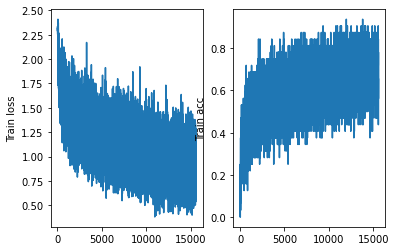

Apprentissage terminé


In [ ]:
train(testloader, trainloader, net, optimizer, criterion, n_epoch=10)

  0%|          | 0/313 [00:00<?, ?it/s]

Accuracy: 0.626


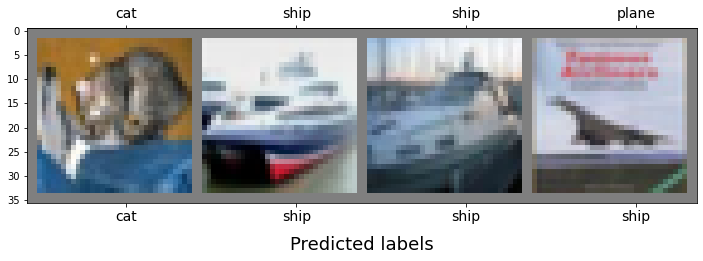

In [ ]:
validate(testloader, net)

## Avec mixup

In [ ]:
class NetMixup(nn.Module):
    def __init__(self):
        super(NetMixup, self).__init__()
        self.mixup = MixUpModule()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x, labels=None):

        if labels is not None:
          batch_size = x.size(0)
          indexes = torch.randperm(batch_size)
          x_shuffle = x[indexes]
          labels_shuffle = labels[indexes]
          x, labels_mix = self.mixup(x, x_shuffle, labels, labels_shuffle)

        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        if labels is not None:
          return x, labels_mix.long()
        return x

In [ ]:
netMixup = NetMixup().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(netMixup.parameters(), lr=0.001)

Epoch 0.
Train.


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Test accuracy: 0.276
Epoch 1.
Train.


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Test accuracy: 0.273
Epoch 2.
Train.


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Test accuracy: 0.254
Epoch 3.
Train.


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Test accuracy: 0.327
Epoch 4.
Train.


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Test accuracy: 0.295
Epoch 5.
Train.


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Test accuracy: 0.331
Epoch 6.
Train.


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Test accuracy: 0.314
Epoch 7.
Train.


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Test accuracy: 0.325
Epoch 8.
Train.


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Test accuracy: 0.310
Epoch 9.
Train.


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Test accuracy: 0.347
Epoch 10.
Train.


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Test accuracy: 0.341
Epoch 11.
Train.


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Test accuracy: 0.340
Epoch 12.
Train.


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Test accuracy: 0.330
Epoch 13.
Train.


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Test accuracy: 0.343
Epoch 14.
Train.


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Test accuracy: 0.331
Epoch 15.
Train.


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Test accuracy: 0.332
Epoch 16.
Train.


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Test accuracy: 0.342
Epoch 17.
Train.


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Test accuracy: 0.348
Epoch 18.
Train.


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Test accuracy: 0.343
Epoch 19.
Train.


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Test accuracy: 0.390
Epoch 20.
Train.


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Test accuracy: 0.340
Epoch 21.
Train.


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Test accuracy: 0.349
Epoch 22.
Train.


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Test accuracy: 0.336
Epoch 23.
Train.


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Test accuracy: 0.344
Epoch 24.
Train.


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Test accuracy: 0.343
Epoch 25.
Train.


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Test accuracy: 0.341
Epoch 26.
Train.


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Test accuracy: 0.347
Epoch 27.
Train.


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Test accuracy: 0.356
Epoch 28.
Train.


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Test accuracy: 0.349
Epoch 29.
Train.


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Test accuracy: 0.353


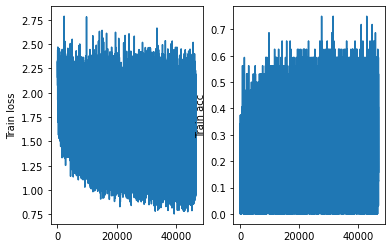

Apprentissage terminé


In [ ]:
train(testloader, trainloader, netMixup, optimizer, criterion, use_mixup=True, n_epoch=30)